# Localised reduced basis generation

Here we just test the ground for potential adaptive algorithms. Given that we have a field $a(y)$ generated from a particular $y\in\mathbb{R}^d$, then what happens if we generate our reduced basis in a small cube around that $y$.

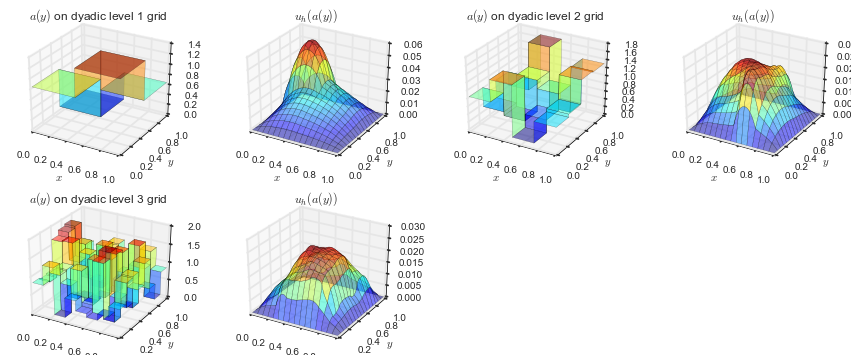

In [3]:
import numpy as np
import importlib
import dyadic_fem as df
import point_generator as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
importlib.reload(pg)
%matplotlib inline

fem_div = 7

a_bar = 1.0
c = 0.9

np.random.seed(1)
y_4 = 2 * np.random.random(2**1 * 2**1) - 1
a_4 = df.DyadicPWConstant(a_bar + c * y_4.reshape([2**1, 2**1]), div=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

np.random.seed(1)
y_16 = 2 * np.random.random(2**2 * 2**2) - 1
a_16 = df.DyadicPWConstant(a_bar + c * y_16.reshape([2**2, 2**2]), div=2)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

np.random.seed(1)
y_64 = 2 * np.random.random(2**3 * 2**3) - 1
a_64 = df.DyadicPWConstant(a_bar + c * y_64.reshape([2**3, 2**3]), div=3)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 4, 1, projection='3d')
a_4.plot(ax, title='$a(y)$ on dyadic level 1 grid')
ax = fig.add_subplot(2, 4, 2, projection='3d')
fem_4.u.plot(ax, title='$u_h(a(y))$')
ax = fig.add_subplot(2, 4, 3, projection='3d')
a_16.plot(ax, title='$a(y)$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 4, 4, projection='3d')
fem_16.u.plot(ax, title='$u_h(a(y))$')
ax = fig.add_subplot(2, 4, 5, projection='3d')
a_64.plot(ax, title='$a(y)$ on dyadic level 3 grid')
ax = fig.add_subplot(2, 4, 6, projection='3d')
fem_64.u.plot(ax, title='$u_h(a(y))$')
plt.show()

In [10]:
basis_div = 2

m = 120

np.random.seed(4)

pg_full = pg.MonteCarlo(d=16, n=m, lims=[-1, 1])

tight_box = np.clip(np.array([y_16-0.1, y_16+0.1]), -1.0, 1.0)
pg_tight = pg.MonteCarlo(d=16, n=m, lims=tight_box)

tighter_box = np.clip(np.array([y_16-0.01, y_16+0.01]), -1.0, 1.0)
pg_tighter = pg.MonteCarlo(d=16, n=m, lims=tighter_box)

Vn, Vn_red_fields = df.make_reduced_basis(n=m, field_div=basis_div, fem_div=fem_div, point_dictionary=pg_full, \
                                          space='H1', a_bar=a_bar, c=c)
Vn_tight, Vn_tight_fields = df.make_reduced_basis(n=m, field_div=basis_div, point_dictionary=pg_tight, \
                                                  fem_div=fem_div, space='H1', a_bar=a_bar, c=c)
Vn_tighter, Vn_tighter_fields = df.make_reduced_basis(n=m, field_div=basis_div, point_dictionary=pg_tighter, \
                                                      fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

ns = range(2,m+1,2)

err = np.zeros((len(ns), 3))
for i, n in enumerate(ns):
    Vn_n = Vn.subspace(slice(0,n))
    Vn_tight_n = Vn_tight.subspace(slice(0,n))
    Vn_tighter_n = Vn_tighter.subspace(slice(0,n))
    
    err[i, 0] = (Vn_n.project(fem_16.u) - fem_16.u).norm(space='H1')
    err[i, 1] = (Vn_tight_n.project(fem_16.u) - fem_16.u).norm(space='H1')   
    err[i, 2] = (Vn_tighter_n.project(fem_16.u) - fem_16.u).norm(space='H1')

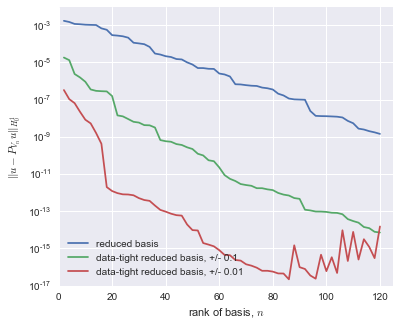

In [11]:
f, ax = plt.subplots(figsize=(6, 5))

ax.set(yscale="log")
plt.plot(ns, err[:,0], label='reduced basis')
plt.plot(ns, err[:,1], label='data-tight reduced basis, +/- 0.1')
plt.plot(ns, err[:,2], label='data-tight reduced basis, +/- 0.01')
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
ax.set_xlim([0, 125])
plt.legend(loc=3)
plt.savefig('tight_data_projections.pdf')
plt.show()